In [16]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Some Utility Functions

In [34]:
def labels_sorted(ax, **kwargs):
    handles, labels = ax.get_legend_handles_labels()
    hl = sorted(zip(handles, labels),
                key=lambda x: x[1])
    handles2, labels2 = zip(*hl)
    return ax.legend(handles2, labels2, **kwargs)

# Country-to-Region Mapping

In [18]:
# apply region mapping
mapping = pd.read_csv('region_mapping.csv').set_index('cntry_code')
regions = sorted(set(mapping.wbregion2.dropna()))
palette = sns.color_palette(sns.hls_palette(n_colors=len(regions), l=.4))
region_colors = {r: palette.pop() for r in regions}

# Read in Data For Projected Ginis

In [19]:
# import and clean up
df = pd.read_csv('adjusted_multi_single.csv') # result of smooth.ipynb
df.columns = ['scenario'] + list(df.columns[1:])
df.columns.name = 'iso'
df = df[df.scenario.str.startswith('mSSP')]
df.scenario = df.scenario.apply(lambda x: x[1:])
df = df.set_index(['scenario', 'year']).stack().reset_index()#.unstack('year').reset_index()
df['region'] = df['iso'].apply(lambda i: mapping.loc[i])
df.head()

,scenario,year,iso,0,region
0,SSP1,2011,AUT,26.106634,Advanced Economies
1,SSP1,2011,BEL,27.500149,Advanced Economies
2,SSP1,2011,BGR,36.457249,Central Asia & Europe
3,SSP1,2011,BLR,36.966496,Central Asia & Europe
4,SSP1,2011,BOL,54.783241,Latin America & Caribbean


In [20]:
# move india and remove low-count regions
rm = ['Middle East & North Africa', 'South Asia']
df.loc[df.iso == 'IND', 'region'] = 'Eastern Asia & the Pacific'
df = df.drop(df[df.region.isin(rm)].region.index)

# Projected Gini Figures

In [21]:
pdf = df.copy()
pdf.columns = ['Scenario', 'Year', 'ISO', 'Gini', 'Region']
pdf = pdf.set_index('Scenario')
pdf.head()

,Year,ISO,Gini,Region
Scenario,,,,
SSP1,2011,AUT,26.106634,Advanced Economies
SSP1,2011,BEL,27.500149,Advanced Economies
SSP1,2011,BGR,36.457249,Central Asia & Europe
SSP1,2011,BLR,36.966496,Central Asia & Europe
SSP1,2011,BOL,54.783241,Latin America & Caribbean


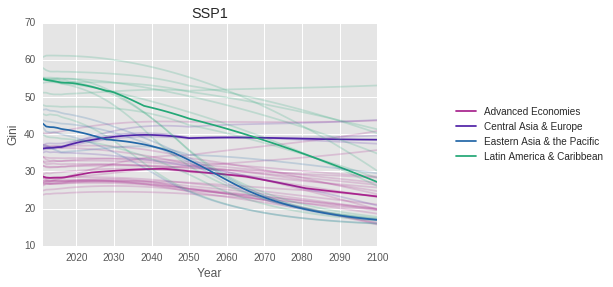

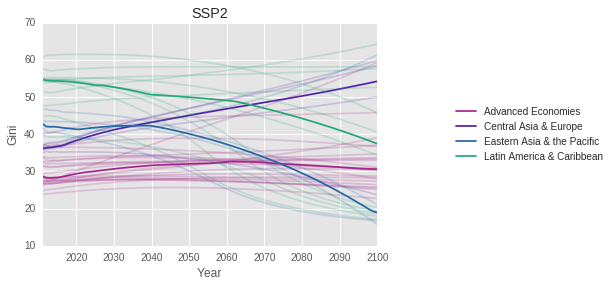

In [22]:
pregions = sorted(set(pdf.Region))
for ssp in sorted(set(pdf.index.values))[:2]:
    # all lines
    g = sns.tsplot(data=pdf.loc[ssp],
                   value='Gini', time='Year', unit='ISO', condition='Region', color=region_colors, 
                   err_style='unit_traces', estimator=np.median)
    # median with bands
    labels_sorted(g, loc='right', bbox_to_anchor=(1.7, 0.5))
    sns.plt.title(ssp)
    plt.show()
    plt.clf()

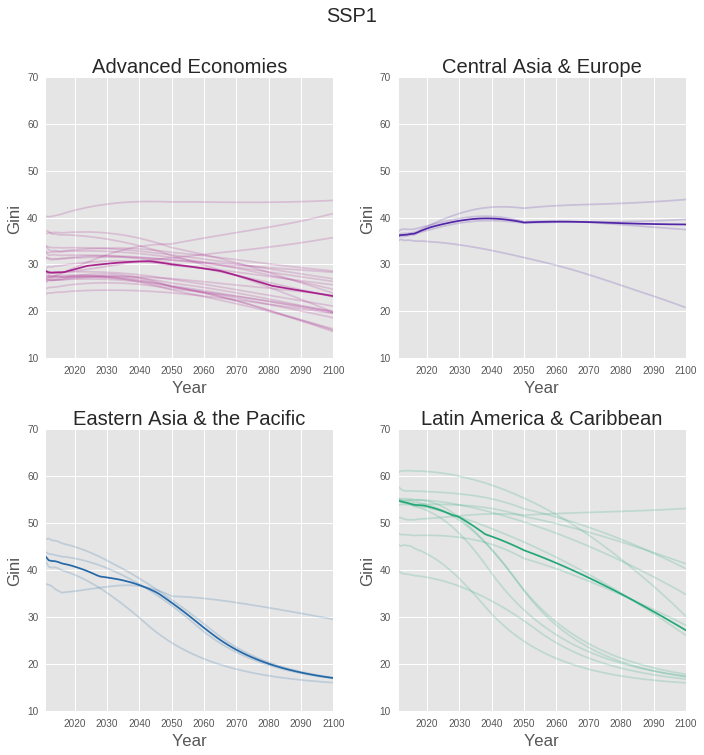

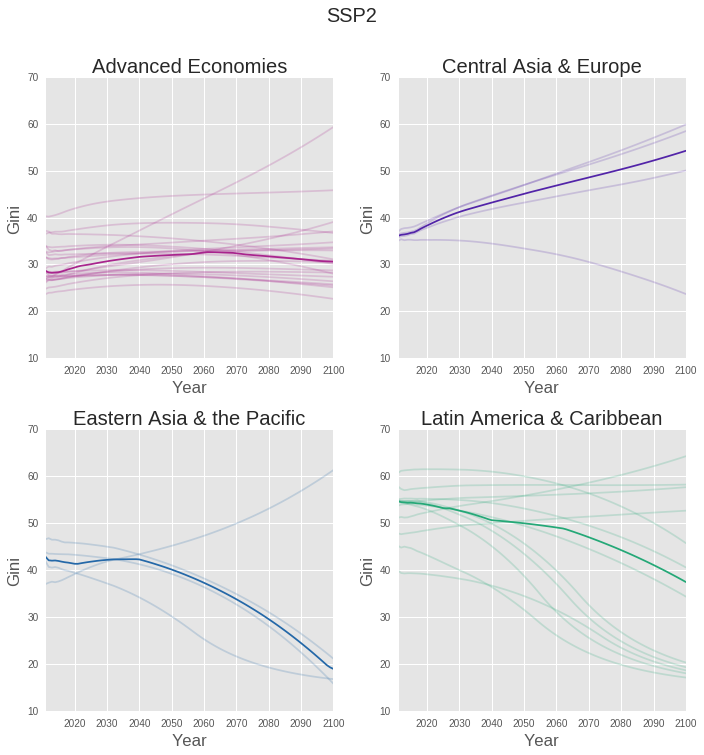

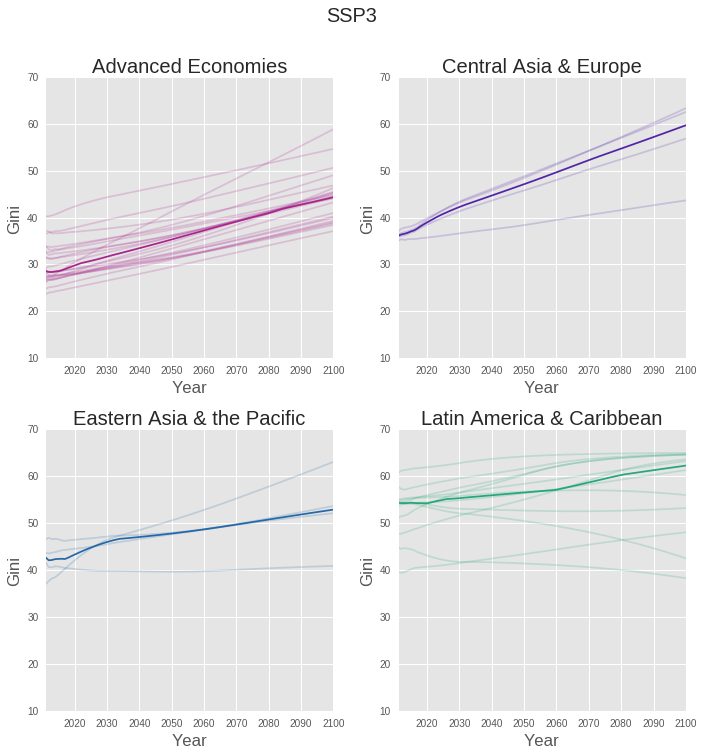

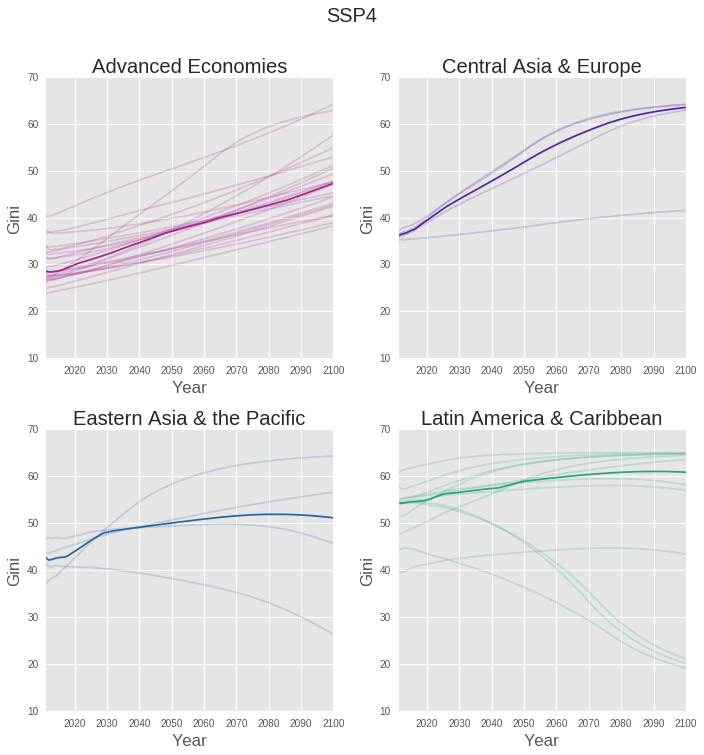

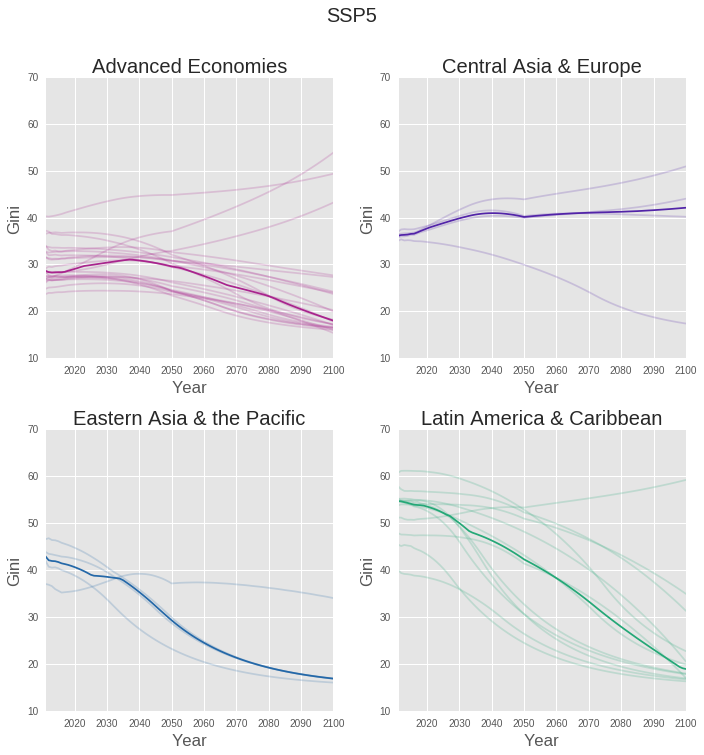

In [28]:
pregions = sorted(set(pdf.Region))
plt.rcParams.update({'font.size': 14})
for ssp in sorted(set(pdf.index.values)):
    # all lines
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))
    for ax, reg in zip(axs.ravel(), pregions):
        data = pdf.loc[ssp]
        data = data[data.Region == reg]
        g = sns.tsplot(data=data,
                       value='Gini', time='Year', unit='ISO', condition='Region', color=region_colors, 
                       err_style='unit_traces', estimator=np.median,
                       ax=ax, legend=False)
        ax.set_title(reg)
        ax.set_ylim(10, 70)
    title = fig.suptitle(ssp, fontsize=20, y=1.05)
    plt.tight_layout()
    plt.savefig('50_{}.png'.format(ssp), dpi=300, bbox_inches='tight', bbox_extra_artists=[title])
    plt.show()
    plt.clf()

# Regressed Ginis

In [24]:
rdf = pd.read_csv('../econ/nbs/data/projected_ginis_full.csv', index_col=[0, 1])
rdf.columns.name = 'iso'
rdf = rdf.stack().reset_index()
common_isos = set(mapping.index.values).intersection(set(rdf['iso']))
rdf = rdf[rdf.iso.isin(common_isos)]
rdf['region'] = rdf['iso'].apply(lambda i: mapping.loc[i])
rdf = rdf[~rdf.region.isnull()]
rdf.head()

,scenario,year,iso,0,region
0,SSP1,2011,ABW,49.278088,Latin America & Caribbean
1,SSP1,2011,AFG,33.800000,Central Asia & Europe
2,SSP1,2011,AGO,48.720000,Sub-Saharan Africa
3,SSP1,2011,ALB,29.215000,Central Asia & Europe
4,SSP1,2011,ARE,41.480451,Middle East & North Africa


In [25]:
rdf.columns = ['Scenario', 'Year', 'ISO', 'Gini', 'Region']
rdf = rdf.set_index('Scenario')
rdf.head()

,Year,ISO,Gini,Region
Scenario,,,,
SSP1,2011,ABW,49.278088,Latin America & Caribbean
SSP1,2011,AFG,33.800000,Central Asia & Europe
SSP1,2011,AGO,48.720000,Sub-Saharan Africa
SSP1,2011,ALB,29.215000,Central Asia & Europe
SSP1,2011,ARE,41.480451,Middle East & North Africa


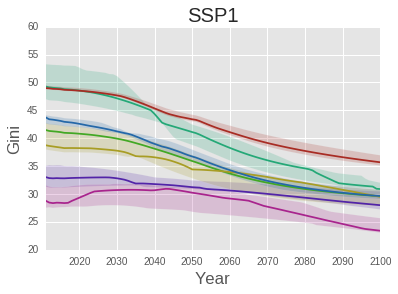

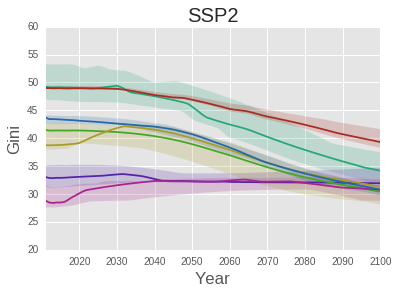

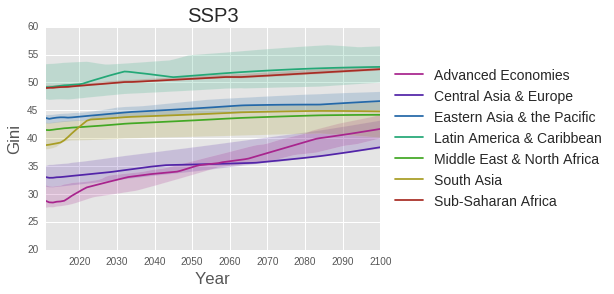

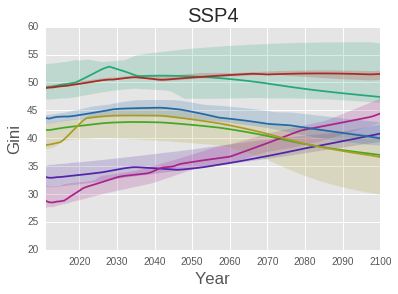

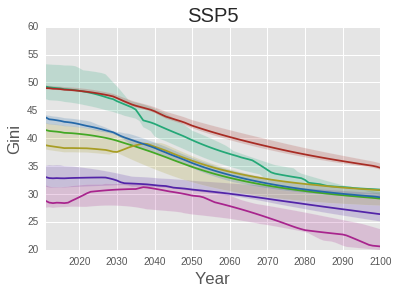

In [39]:
for ssp in sorted(set(rdf.index.values)):
    data = rdf.loc[ssp]
    g = sns.tsplot(data=data, 
                   value='Gini', time='Year', unit='ISO', condition='Region', color=region_colors, 
                   estimator=np.median)
    if ssp == 'SSP3':
        leg = labels_sorted(g, loc='right', bbox_to_anchor=(1.7, 0.5), fontsize=14)
    else:
        g.legend_.remove()
    g.set_ylim(20, 60)
    sns.plt.title(ssp)
    extras = [leg] if ssp == 'SSP3' else []
    plt.savefig('all_{}.png'.format(ssp), dpi=300, bbox_inches='tight', bbox_extra_artists=extras)
    plt.show()
    plt.clf()

# Medians of Projected Values

In [51]:
mdf = pdf.reset_index()
mdf = mdf[mdf.Region != 'Central Asia & Europe']
mdf['Region'][mdf.ISO == 'IND'] = 'South Asia' # south asia only india

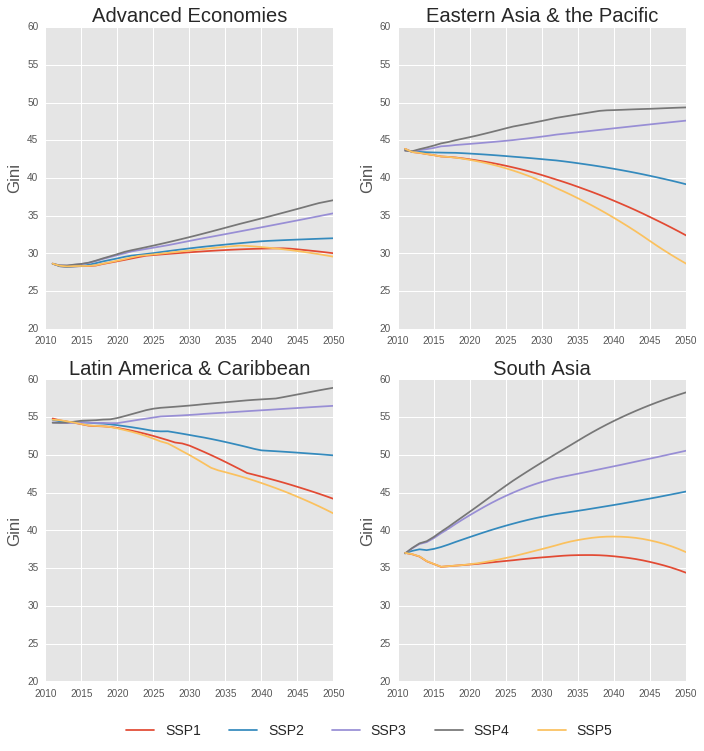

In [110]:
mregions = sorted(set(mdf.Region))
plt.rcParams.update({'font.size': 14})
data = mdf.groupby(['Region', 'Scenario', 'Year']).median()

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for ax, reg in zip(axs.ravel(), mregions):
    data.loc[reg].unstack('Scenario').plot(ax=ax, legend=False)
    ax.set_title(reg)
    ax.set_ylim(20, 60)
    ax.set_xlim(2010, 2050)
    ax.set_ylabel('Gini')
    ax.set_xlabel('')
handles, labels = ax.get_legend_handles_labels()
labels = sorted(set(mdf.Scenario))
legend = plt.legend(handles, labels, loc='upper center', bbox_to_anchor=(-.1,-0.1),
          fontsize=14, ncol=5)
plt.tight_layout()
plt.savefig('medians.png'.format(ssp), dpi=300, bbox_inches='tight', bbox_extra_artists=[legend])
plt.show()
plt.clf()